Instalação das bibliotecas

In [560]:

!pip install --quiet pandas numpy matplotlib scikit-learn tensorflow


MÓDULO 1: IMPORTAÇÃO E PREPARAÇÃO DOS DADOS BRUTOS

In [561]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

df = pd.read_csv("daily-minimum-temperatures-in-me.csv", sep=',', engine='python', on_bad_lines='skip')

if df.index.name == 'Date':
    df = df.reset_index()

temp_col_name_old = df.columns[1]
df.rename(columns={temp_col_name_old: 'Temperature'}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

df['Temperature'] = pd.to_numeric(df['Temperature'].astype(str).str.strip(), errors='coerce')
df.dropna(subset=['Temperature'], inplace=True)

print("Módulo 1 (LSTM) concluído. Dados carregados: ", len(df))
df.head()

Módulo 1 (LSTM) concluído. Dados carregados:  3647


,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


MÓDULO EXTRA 1.5: VISUALIZAÇÃO DOS DADOS BRUTOS

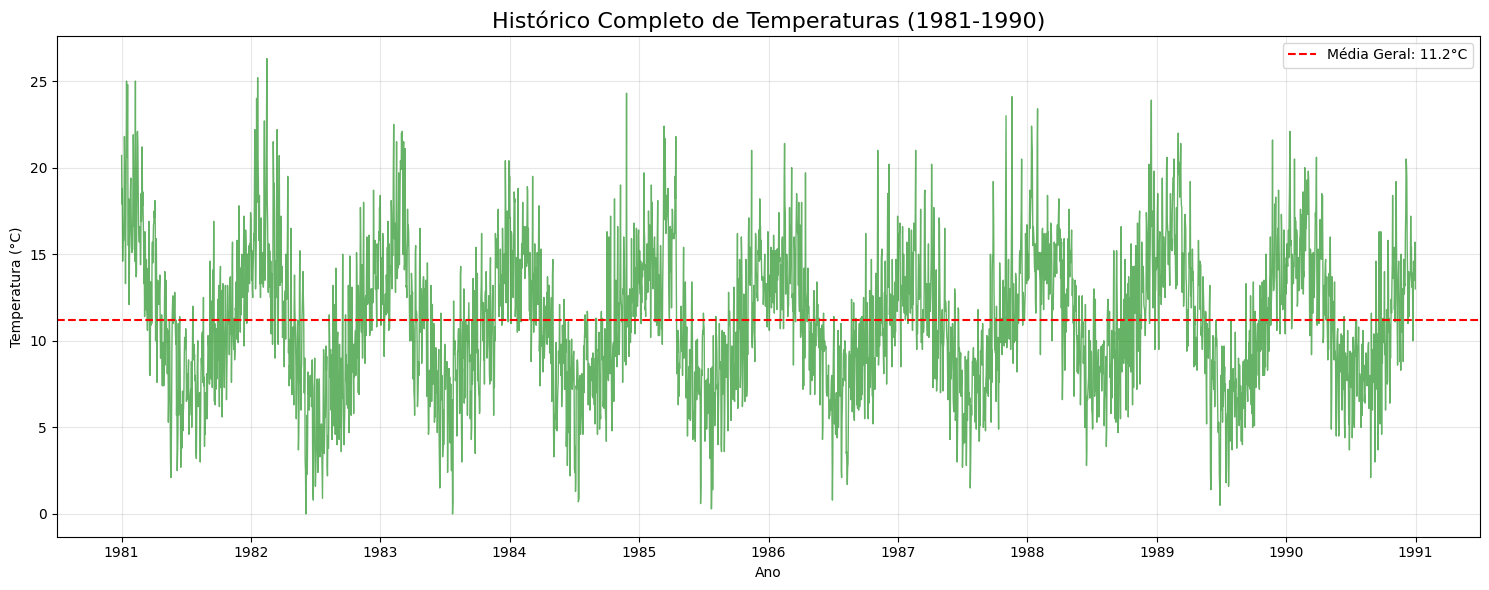

In [562]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Temperature'], color='green', alpha=0.6, linewidth=1)
plt.title('Histórico Completo de Temperaturas (1981-1990)', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.grid(True, alpha=0.3)

media_temp = df['Temperature'].mean()
plt.axhline(y=media_temp, color='red', linestyle='--', label=f'Média Geral: {media_temp:.1f}°C')
plt.legend()

plt.tight_layout()
plt.show()

MÓDULO 2: CONFIGURAÇÕES E FUNÇÃO AUXILIAR

In [563]:
TAMANHO_JANELA = 60
N_SPLITS = 5          # Número de dobras para o K-Fold
CELULAS = 45
BATCH_SIZE = 32
EPOCHS = 40

def criar_janelas(dados, tamanho_janela):
    """
    Cria os pares X (passado) e y (futuro) para a rede neural.
    """
    X, y = [], []
    for i in range(tamanho_janela, len(dados)):
        X.append(dados[i-tamanho_janela:i, 0])
        y.append(dados[i, 0])

    return np.array(X), np.array(y)

print(f"Módulo 2 concluído. Configurado para janela de {TAMANHO_JANELA} dias.")

Módulo 2 concluído. Configurado para janela de 60 dias.


MÓDULO 3: LOOP DE TREINAMENTO K-FOLD

In [564]:
data_raw = df[['Temperature']].values
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
rmse_scores = []
fold_no = 1
history_dict = {}

print("Iniciando treinamento com K-Fold (LSTM) com monitoramento de curvas...\n")

for train_index, test_index in tscv.split(data_raw):
    train_data, test_data = data_raw[train_index], data_raw[test_index]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)

    test_input = np.concatenate((train_data[-TAMANHO_JANELA:], test_data))
    test_scaled = scaler.transform(test_input)

    X_train, y_train = criar_janelas(train_scaled, TAMANHO_JANELA)
    X_test, y_test = criar_janelas(test_scaled, TAMANHO_JANELA)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=CELULAS, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=0)

    history_dict = history.history

    predictions = model.predict(X_test, verbose=0)
    predictions_inv = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = math.sqrt(mean_squared_error(y_test_inv, predictions_inv))
    rmse_scores.append(rmse)

    print(f"Fold {fold_no}: RMSE = {rmse:.4f} °C")
    fold_no += 1

print("\n" + "="*30)
print(f"Média Final RMSE (LSTM): {np.mean(rmse_scores):.4f} °C")
print("="*30)

Iniciando treinamento com K-Fold (LSTM) com monitoramento de curvas...

Fold 1: RMSE = 2.7287 °C
Fold 2: RMSE = 2.5067 °C
Fold 3: RMSE = 2.3630 °C
Fold 4: RMSE = 2.4585 °C
Fold 5: RMSE = 2.2377 °C

Média Final RMSE (LSTM): 2.4589 °C


MÓDULO 3.3: COMPARAÇÃO TREINO VS TESTE

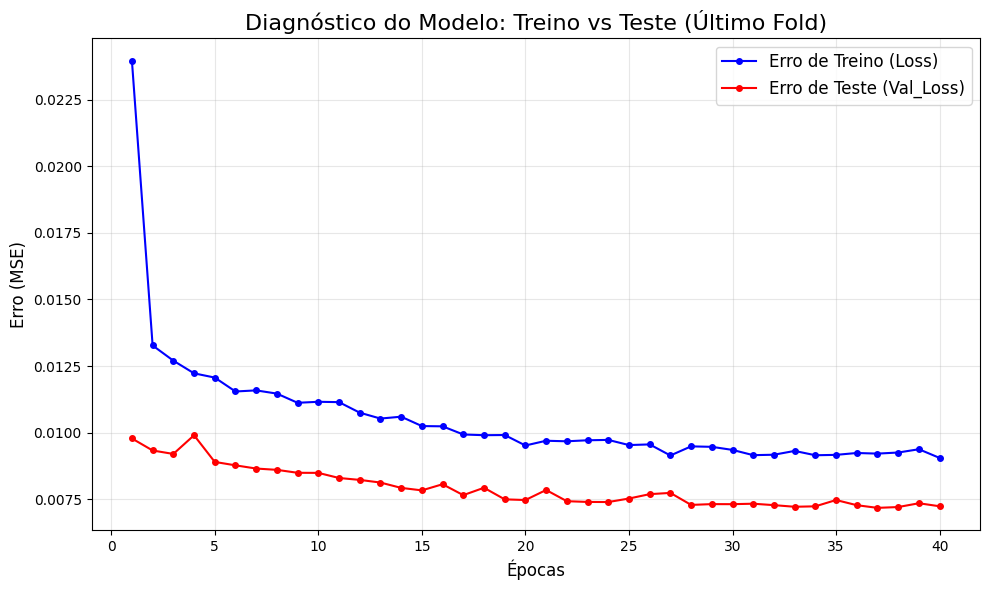


--- COMO LER ESTE GRÁFICO ---
SUCESSO: O modelo está generalizando bem (As linhas estão próximas).
Pode seguir para a previsão final.


In [565]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

loss_treino = history_dict['loss']
loss_teste = history_dict['val_loss']
epocas = range(1, len(loss_treino) + 1)

plt.plot(epocas, loss_treino, 'bo-', label='Erro de Treino (Loss)', linewidth=1.5, markersize=4)
plt.plot(epocas, loss_teste, 'ro-', label='Erro de Teste (Val_Loss)', linewidth=1.5, markersize=4)

plt.title('Diagnóstico do Modelo: Treino vs Teste (Último Fold)', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Erro (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.annotate('Ideal: Linhas descem juntas\ne ficam próximas',
             xy=(len(epocas)/2, max(loss_teste)/2),
             xytext=(len(epocas)/2, max(loss_teste)),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


print("\n--- COMO LER ESTE GRÁFICO ---")
if loss_teste[-1] > loss_treino[-1] * 1.5:
    print("ALERTA: Possível Overfitting (A linha vermelha está muito acima da azul).")
    print("Sugestão: Aumentar o Dropout ou reduzir as Celulas.")
else:
    print("SUCESSO: O modelo está generalizando bem (As linhas estão próximas).")
    print("Pode seguir para a previsão final.")

MÓDULO EXTRA 3.5: ESTABILIDADE DOS FOLDS

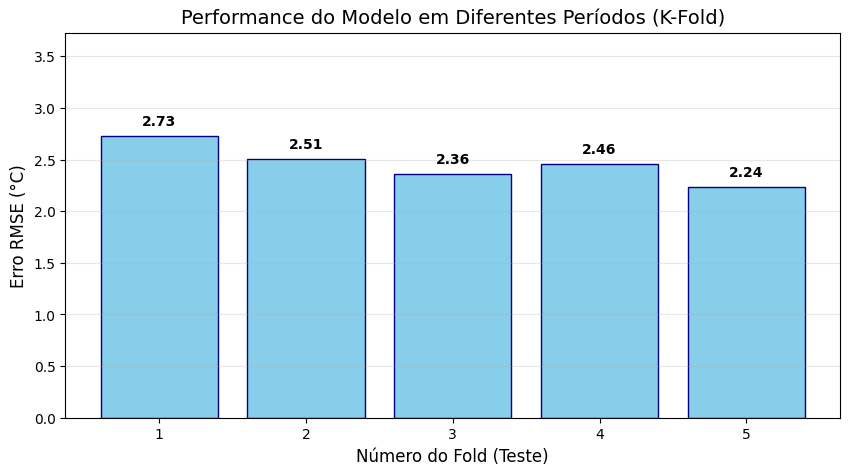

In [566]:

plt.figure(figsize=(10, 5))
folds = range(1, len(rmse_scores) + 1)
plt.bar(folds, rmse_scores, color='skyblue', edgecolor='navy')

plt.title('Performance do Modelo em Diferentes Períodos (K-Fold)', fontsize=14)
plt.xlabel('Número do Fold (Teste)', fontsize=12)
plt.ylabel('Erro RMSE (°C)', fontsize=12)
plt.xticks(folds)
plt.ylim(0, max(rmse_scores) + 1)

for i, v in enumerate(rmse_scores):
    plt.text(i + 1, v + 0.1, f"{v:.2f}", ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

MÓDULO 4: VISUALIZAÇÃO E ANÁLISE DOS RESULTADOS

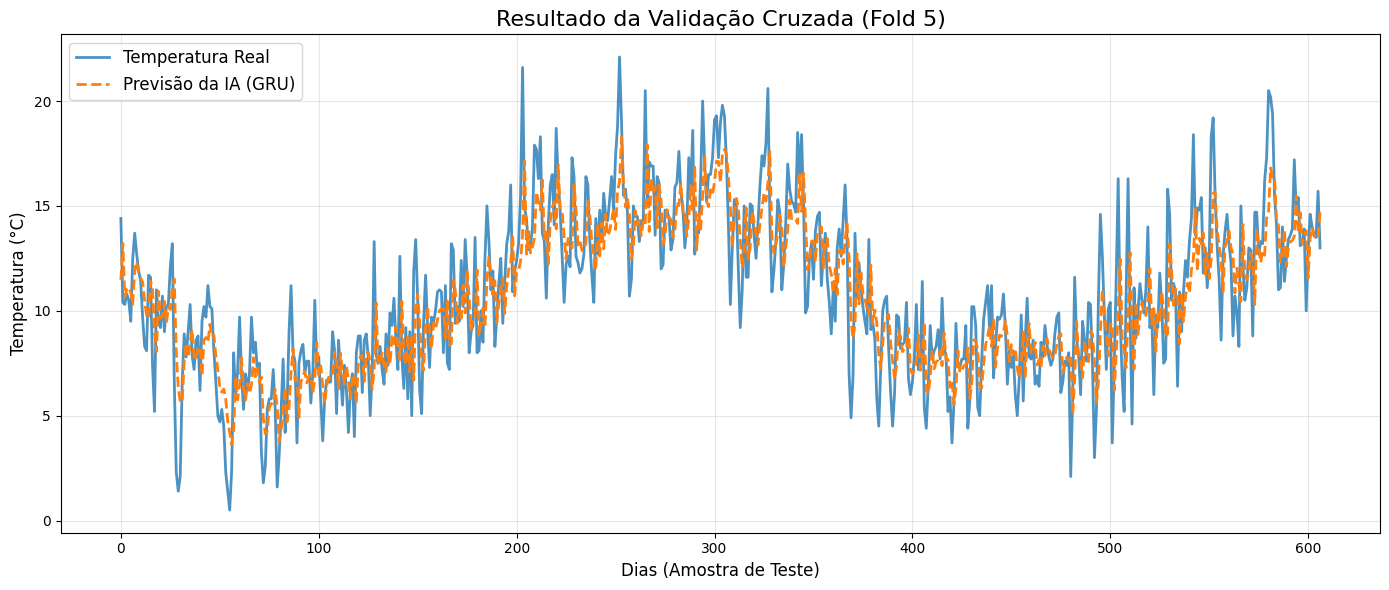


--- RELATÓRIO DE PRECISÃO ---
Erro Médio Absoluto (MAE): 1.75 °C
Isso significa que, em média, a IA erra a temperatura por 1.75 graus.

--- AMOSTRA DOS ÚLTIMOS 5 DIAS ---
DIA        | REAL       | PREVISTO   | DIFERENÇA 
--------------------------------------------------
Dia -5     | 14.00      | 13.97      | 0.03      
Dia -4     | 13.60      | 13.56      | 0.04      
Dia -3     | 13.50      | 13.48      | 0.02      
Dia -2     | 15.70      | 13.45      | 2.25      
Dia -1     | 13.00      | 14.72      | 1.72      


In [567]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

plt.plot(y_test_inv, label='Temperatura Real', color='#1f77b4', linewidth=2, alpha=0.8)

plt.plot(predictions_inv, label='Previsão da IA (GRU)', color='#ff7f0e', linestyle='--', linewidth=2)

plt.title(f'Resultado da Validação Cruzada (Fold {fold_no-1})', fontsize=16)
plt.xlabel('Dias (Amostra de Teste)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

erros_absolutos = np.abs(y_test_inv - predictions_inv)
erro_medio = np.mean(erros_absolutos)

print(f"\n--- RELATÓRIO DE PRECISÃO ---")
print(f"Erro Médio Absoluto (MAE): {erro_medio:.2f} °C")
print(f"Isso significa que, em média, a IA erra a temperatura por {erro_medio:.2f} graus.")

print("\n--- AMOSTRA DOS ÚLTIMOS 5 DIAS ---")
print(f"{'DIA':<10} | {'REAL':<10} | {'PREVISTO':<10} | {'DIFERENÇA':<10}")
print("-" * 50)
for i in range(5, 0, -1):
    real = y_test_inv[-i][0]
    prev = predictions_inv[-i][0]
    diff = abs(real - prev)
    print(f"Dia -{i:<5} | {real:<10.2f} | {prev:<10.2f} | {diff:<10.2f}")

MÓDULO EXTRA: Acurácia em Porcentagem

In [568]:
epsilon = 1e-10
erro_percentual = np.mean(np.abs((y_test_inv - predictions_inv) / (y_test_inv + epsilon))) * 100
acuracia_percentual = 100 - erro_percentual

print(f"Erro percentual médio (MAPE): {erro_percentual:.2f}%")
print(f"Acurácia aproximada do modelo: {acuracia_percentual:.2f}%")

Erro percentual médio (MAPE): 22.06%
Acurácia aproximada do modelo: 77.94%


MÓDULO 5: TREINO FINAL, GRÁFICOS E PREVISÃO

Iniciando treinamento final (LSTM) com 100% dos dados...
Modelo Final LSTM Treinado!


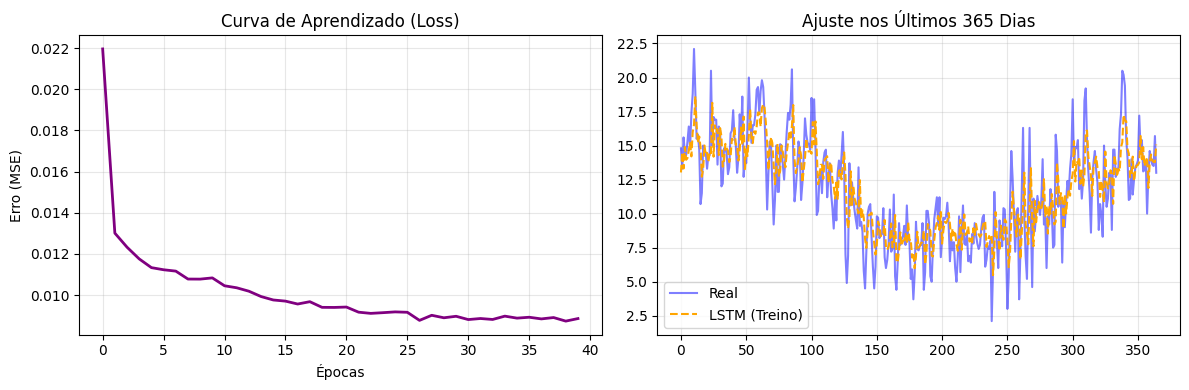


PREVISÃO PARA AMANHÃ (LSTM): 13.30 °C


In [569]:
import matplotlib.pyplot as plt

print("Iniciando treinamento final (LSTM) com 100% dos dados...")

scaler_final = MinMaxScaler(feature_range=(0, 1))
dados_totais_scaled = scaler_final.fit_transform(data_raw)

X_total, y_total = criar_janelas(dados_totais_scaled, TAMANHO_JANELA)
X_total = np.reshape(X_total, (X_total.shape[0], X_total.shape[1], 1))

model_final = Sequential()
model_final.add(Input(shape=(X_total.shape[1], 1)))
model_final.add(LSTM(units=CELULAS, return_sequences=False))
model_final.add(Dropout(0.2))
model_final.add(Dense(1))

model_final.compile(optimizer='adam', loss='mean_squared_error')

history = model_final.fit(X_total, y_total, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print("Modelo Final LSTM Treinado!")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='purple', linewidth=2)
plt.title('Curva de Aprendizado (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Erro (MSE)')
plt.grid(True, alpha=0.3)

previsao_total_scaled = model_final.predict(X_total, verbose=0)
previsao_total = scaler_final.inverse_transform(previsao_total_scaled)
y_total_real = scaler_final.inverse_transform(y_total.reshape(-1, 1))

plt.subplot(1, 2, 2)
dias_zoom = 365
plt.plot(y_total_real[-dias_zoom:], label='Real', color='blue', alpha=0.5)
plt.plot(previsao_total[-dias_zoom:], label='LSTM (Treino)', color='orange', linestyle='--')
plt.title(f'Ajuste nos Últimos {dias_zoom} Dias')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ultima_janela = dados_totais_scaled[-TAMANHO_JANELA:]
ultima_janela = np.reshape(ultima_janela, (1, TAMANHO_JANELA, 1))
previsao_scaled = model_final.predict(ultima_janela, verbose=0)
previsao_final = scaler_final.inverse_transform(previsao_scaled)

print("\n" + "="*40)
print(f"PREVISÃO PARA AMANHÃ (LSTM): {previsao_final[0][0]:.2f} °C")
print("="*40)

In [570]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [571]:
#import tensorflow as tf
#tf.config.list_physical_devices('GPU')